In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import re
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data Preparation

In [2]:
df = pd.read_csv('../data/raw/train_1.csv', index_col=None)

#### Select page

In [3]:
page_index = 86431

In [4]:
time_serie = df.loc[[page_index]]

#### Select only time series columns

In [5]:
# Regular expression to match date format "YYYY-MM-DD"
date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}')

# Filter columns based on the regular expression
filtered_columns = [col for col in df.columns if date_pattern.match(col)]

# Create a new DataFrame with only the filtered columns
time_serie = time_serie[filtered_columns]

In [6]:
time_serie

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
86431,286962.0,284409.0,285051.0,243782.0,235765.0,296575.0,289924.0,281141.0,284218.0,268278.0,...,291616.0,308642.0,276147.0,284671.0,372982.0,297016.0,281325.0,225793.0,223610.0,198956.0


#### Prepare dataframe

In [7]:
# Creating a DataFrame for test dates and predicted values
data = pd.DataFrame({
    'date': pd.to_datetime(time_serie.columns.values),
    'traffic_demand': time_serie.values.flatten(),
})
data.set_index('date', inplace=True) # set date as index

#### Time serie inspection

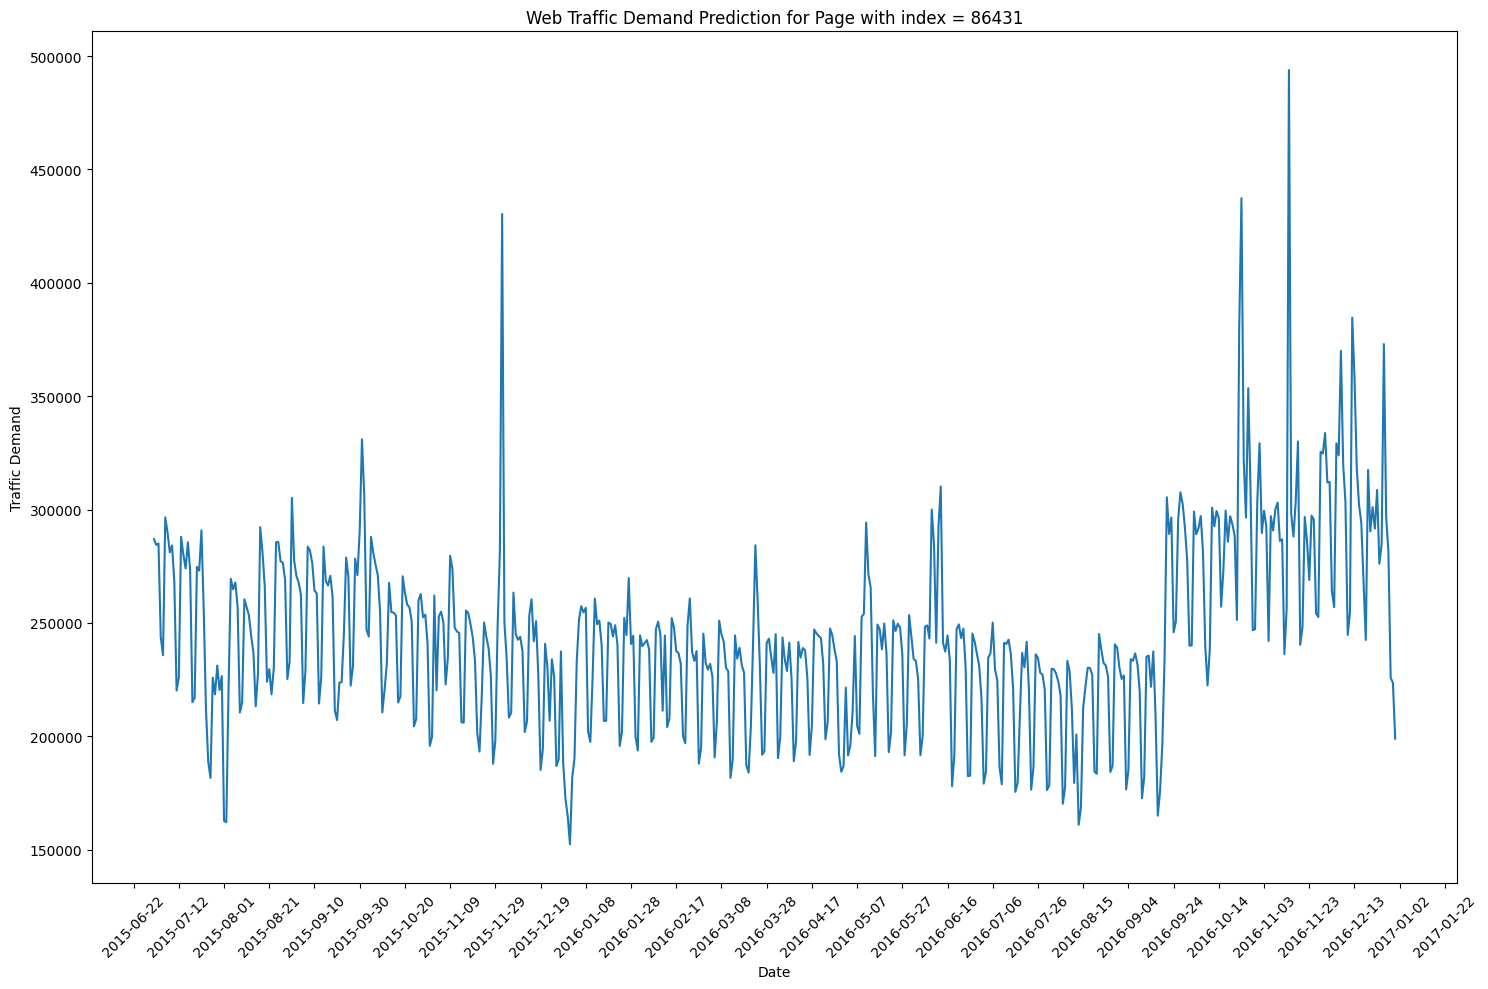

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(data.index, data['traffic_demand'])
plt.title(f'Web Traffic Demand Prediction for Page with index = {page_index}')
plt.xlabel('Date')
plt.ylabel('Traffic Demand')

# Set major ticks to be every 2 days
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))

# Rotate and format the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Data is not stationary, which can be a problem for ARIMA

#### Split training and test data

In [9]:
train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [10]:
print(train.shape)
print(test.shape)

(440, 1)
(110, 1)


#### Missing Values Imputation

Check if there are missing values

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_demand  550 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


There are no missing values, however, in case there should be in other time series, missing values are imputed using forward linear interpolation. NAN values before a certain real value will be filled with 0 and the remaining NAN values will be filled using linear interpolation.

Interpolation must be done on training and set separately to avoid data leakage.

In [12]:
train = train.interpolate(method='linear', limit_direction='forward', axis=0)
test = test.interpolate(method='linear', limit_direction='forward', axis=0)

# Data Modeling

#### Find ARIMA Parameters

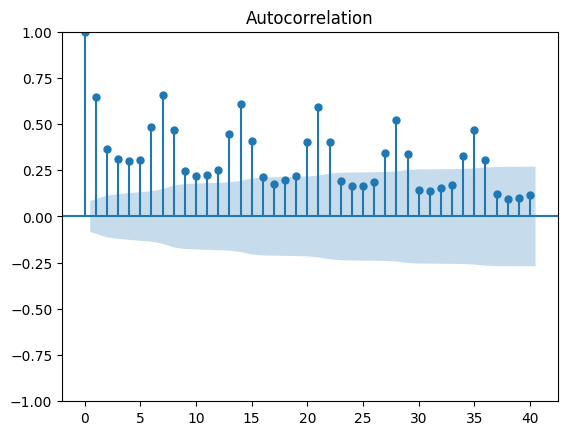

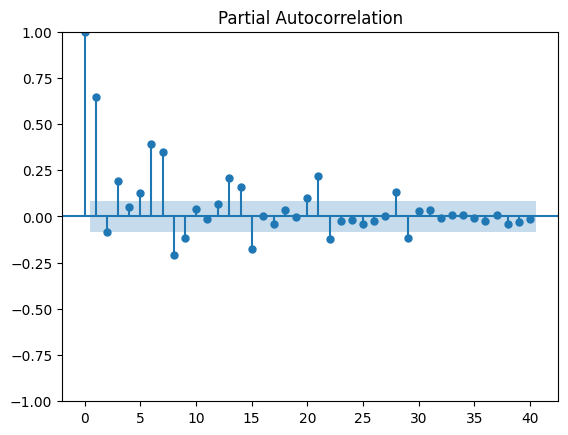

In [13]:
plot_acf(data['traffic_demand'], lags=40)
plot_pacf(data['traffic_demand'], lags=40)
plt.show()

- Autocorrelation plot is to find the moving average component 𝑞.
- Partial Autocorrelation plot is to find the autoregressive component 𝑝
  
For both, the component is when there is a sharp drop

ARIMA(p=1, d=0, q=1) model may be a good starting point

#### Instantiate model

In [14]:
model_train = ARIMA(train['traffic_demand'], order=(1, 0, 1))
model_train_fit = model_train.fit()

/Users/marcopellegrino/miniconda3/envs/marcoenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marcopellegrino/miniconda3/envs/marcoenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marcopellegrino/miniconda3/envs/marcoenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# Data Evaluation

In [15]:
# Forecast on the unseen test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

In [16]:
mse = mean_squared_error(test['traffic_demand'], test_forecast_series)
print('MSE:', mse)
print('RMSE:', mse**0.5)

MSE: 4982147281.203642
RMSE: 70584.32744741315


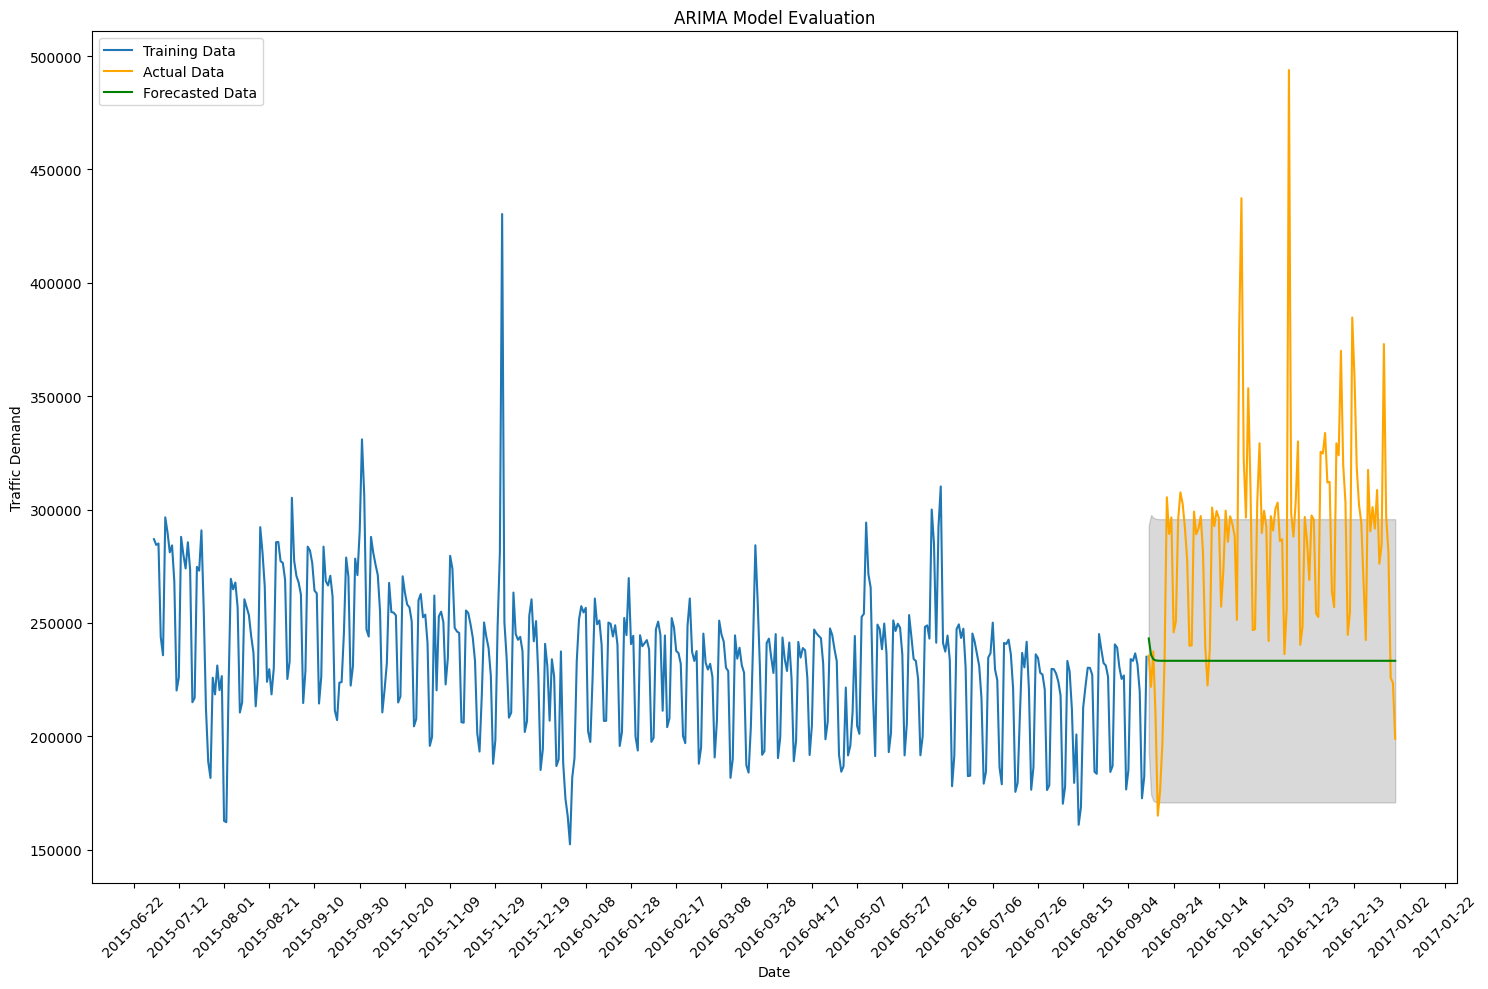

In [17]:
# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(15,10))
plt.plot(train['traffic_demand'], label='Training Data')
plt.plot(test['traffic_demand'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Traffic Demand')
plt.legend()

# Set major ticks to be every 20 days
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))

# Rotate and format the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The plot displays the training data, the actual values from the test set (in orange), and the forecasted values (in green), with the shaded area representing the 95% confidence interval. The model seems to capture the central tendency of the series but fails to account for any potential within-sample variability. This is expected since ARIMA models are typically more effective for data with stable trends or long seasonality, which this series does not seem to show.